# Multi-Agent Research Swarm: Autonomous Collaborative researche System

## Project Overview
This project showcases the development of a sophisticated multi-agent AI system that autonomously researches complex topics and generates comprehensive, well-structured reports.  
Using LangGraph's powerful orchestration, specialized AI agents collaborate seamlessly—each with unique expertise—to produce high-quality research outputs.

---

## Key Technical Achievements
- **Advanced State Management** — Centralized state tracking for research progress across multiple agents  
- **Conditional Workflow Logic** — Dynamic decision-making that adapts based on task completion  
- **Tool Integration** — External search API integration for real-world data gathering  
- **Agent Specialization** — Distinct personas and capabilities mirroring real research teams  

---

## Architecture Highlights
The system uses a **supervisor pattern** where a central controller:
1. Distributes tasks  
2. Monitors progress  

Each agent:
- Operates independently within its domain  
- Contributes to the collective goal  

This architecture scales efficiently and can be extended with additional agents or tools as needed.


In [ ]:
# Install Required Dependencies
!pip install langgraph==0.2.34 langchain==0.3.7 langchain-openai==0.2.9 langchain-community==0.3.7 tavily-python==0.5.0 typing-extensions

# Environment Configuration

## Setting Up API Access
The system requires access to two critical services:

1. **OpenAI API** — Powers the cognitive capabilities of the agents  
2. **Tavily Search API** — Provides real-time web search functionality for research tasks  

These API keys are configured directly in the environment to ensure seamless operation.


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

# API Configuration
os.environ['OPENAI_API_KEY'] = 'sk-'
os.environ['TAVILY_API_KEY'] = 'tvly-'

print("✅ Environment configured successfully")

✅ Environment configured successfully


# Core System Components

## Graph State Architecture
The **GraphState** serves as the central nervous system of the multi-agent swarm.  
It maintains all shared information, including:
- Research plan  
- Collected data  
- Generated summaries  
- Final report  

This state-based approach ensures precise coordination between agents and enables complex conditional workflows.


In [ ]:
from typing import TypedDict, List, Dict, Optional
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
import json

# Initialize the research tool with optimized parameters
tavily_tool = TavilySearchResults(
    max_results=4,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=False
)

# Define the comprehensive state structure
class GraphState(TypedDict):
    """
    Central state management for the multi-agent research system.
    Tracks all aspects of the research workflow from planning to final output.
    """
    original_topic: str                    # User's research query
    plan: List[str]                       # Research subtopics queue
    research_data: Dict[str, List[str]]   # Raw research findings per subtopic
    summaries: Dict[str, str]             # Processed summaries per subtopic
    final_report: str                      # Completed markdown report
    _current_task: Optional[str]           # Active research focus

# Initialize the language model with optimal parameters
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    max_tokens=2000
)

print("✅ Core components initialized")

✅ Core components initialized


# Agent Implementation

## The Research Team
Each agent in the system is designed with a specific role and area of expertise.  
They operate like a coordinated research team, with every member contributing specialized skills toward producing the final output.


In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage

def planner_node(state: GraphState) -> Dict:
    """
    Strategic Research Planner Agent

    Analyzes complex topics and decomposes them into manageable research tasks.
    Creates a logical sequence of investigations that build upon each other.
    """

    planning_prompt = SystemMessage(
        content="""You are an expert research strategist with deep experience in academic and technical research.

        Your task is to create a comprehensive research plan by breaking down the given topic into
        5-7 specific, actionable research questions. Each question should:
        - Build logically on previous questions
        - Cover a distinct aspect of the topic
        - Be specific enough for targeted research
        - Together form a complete investigation

        Format each as a clear, searchable query."""
    )

    user_request = HumanMessage(
        content=f"Create a detailed research plan for: {state['original_topic']}"
    )

    response = llm.invoke([planning_prompt, user_request])

    # Parse the plan into discrete research tasks
    plan_items = [
        item.strip()
        for item in response.content.split('\n')
        if item.strip() and not item.strip().startswith('#')
    ]

    return {"plan": plan_items[:7]}  # Limit to 7 tasks for optimal performance


def research_node(state: GraphState) -> Dict:
    """
    Field Research Agent

    Conducts targeted searches using advanced search capabilities.
    Gathers relevant, high-quality information from diverse sources.
    """

    current_task = state.get('_current_task', '')

    if not current_task:
        return state

    # Execute focused research query
    search_query = f"{current_task} detailed information facts data"
    search_results = tavily_tool.invoke({"query": search_query})

    # Extract and structure research findings
    research_findings = []
    for result in search_results:
        if isinstance(result, dict):
            content = result.get('content', '')
            url = result.get('url', '')
            if content:
                research_findings.append(f"{content}\nSource: {url}")

    # Initialize research data dict if needed
    if state.get('research_data') is None:
        state['research_data'] = {}

    state['research_data'][current_task] = research_findings

    return state


def summarizer_node(state: GraphState) -> Dict:
    """
    Research Synthesis Agent

    Analyzes raw research data and creates concise, informative summaries.
    Ensures key insights are preserved while maintaining clarity.
    """

    current_task = state.get('_current_task', '')
    research_data = state.get('research_data', {}).get(current_task, [])

    if not research_data:
        return state

    synthesis_prompt = SystemMessage(
        content="""You are a technical writer specializing in research synthesis.

        Your task is to analyze the provided research data and create a comprehensive summary that:
        - Captures all key findings and insights
        - Maintains technical accuracy
        - Presents information in a clear, logical flow
        - Includes specific details, statistics, and examples where available
        - Is approximately 2-3 paragraphs in length

        Focus on substance over style - prioritize information density and clarity."""
    )

    research_content = HumanMessage(
        content=f"Research topic: {current_task}\n\nFindings:\n" + "\n---\n".join(research_data[:3])
    )

    response = llm.invoke([synthesis_prompt, research_content])

    # Initialize summaries dict if needed
    if state.get('summaries') is None:
        state['summaries'] = {}

    state['summaries'][current_task] = response.content

    return state


def report_writer_node(state: GraphState) -> Dict:
    """
    Executive Report Writer Agent

    Transforms individual research summaries into a cohesive, professional report.
    Ensures logical flow, proper formatting, and comprehensive coverage.
    """

    summaries = state.get('summaries', {})
    original_topic = state.get('original_topic', '')

    if not summaries:
        return {"final_report": "No research data available for report generation."}

    report_prompt = SystemMessage(
        content="""You are a distinguished technical writer and editor with expertise in creating
        comprehensive research reports.

        Your task is to create a professional, well-structured report that:
        - Opens with an engaging executive summary
        - Organizes content into logical sections with clear headings
        - Weaves individual summaries into a cohesive narrative
        - Uses proper Markdown formatting (# for main title, ## for sections, **bold** for emphasis)
        - Includes transition sentences between sections
        - Concludes with key takeaways and future implications
        - Maintains an authoritative yet accessible tone

        The report should be substantial (1000+ words) and demonstrate deep understanding."""
    )

    # Prepare summaries for integration
    summary_content = "\n\n".join([
        f"### Research Area: {topic}\n{summary}"
        for topic, summary in summaries.items()
    ])

    report_request = HumanMessage(
        content=f"""Create a comprehensive report on: {original_topic}

        Research Summaries:
        {summary_content}"""
    )

    response = llm.invoke([report_prompt, report_request])

    return {"final_report": response.content}


print("✅ All agents successfully implemented")

✅ All agents successfully implemented


# Workflow Orchestration

## Building the Intelligence Graph
The graph structure represents the cognitive flow of the research system.  
Leveraging LangGraph's orchestration capabilities, it creates a dynamic workflow that adapts based on task completion and intelligently routes tasks between agents.


In [ ]:
from typing import Literal

def supervisor_router(state: GraphState) -> Literal["research", "report"]:
    """
    Intelligent routing logic that manages the research workflow.
    Determines whether to continue research or proceed to report generation.
    """

    plan = state.get('plan', [])

    if plan and len(plan) > 0:
        # More research tasks remain
        return "research"
    else:
        # All research complete, generate report
        return "report"


def prepare_research_task(state: GraphState) -> Dict:
    """
    Task preparation node that stages the next research item.
    Manages the research queue and updates the current focus.
    """

    plan = state.get('plan', [])

    if plan:
        # Extract next task from the queue
        current_task = plan.pop(0)
        return {
            "plan": plan,
            "_current_task": current_task
        }

    return state


# Construct the research workflow graph
workflow = StateGraph(GraphState)

# Register all nodes in the workflow
workflow.add_node("planner", planner_node)
workflow.add_node("prepare_task", prepare_research_task)
workflow.add_node("research", research_node)
workflow.add_node("summarize", summarizer_node)
workflow.add_node("write_report", report_writer_node)

# Define the workflow topology
workflow.set_entry_point("planner")

# Create conditional routing from planner
workflow.add_conditional_edges(
    "planner",
    supervisor_router,
    {
        "research": "prepare_task",
        "report": "write_report"
    }
)

# Define the research loop
workflow.add_edge("prepare_task", "research")
workflow.add_edge("research", "summarize")

# Loop back to supervisor for next task
workflow.add_conditional_edges(
    "summarize",
    supervisor_router,
    {
        "research": "prepare_task",
        "report": "write_report"
    }
)

# Set terminal node
workflow.add_edge("write_report", END)

# Compile the workflow into an executable application
app = workflow.compile()

print("✅ Workflow graph successfully compiled")

✅ Workflow graph successfully compiled


# Workflow Visualization

## System Architecture Diagram
Visualizing the agent workflow reveals the sophisticated orchestration behind the scenes.  
Each node represents an agent, and edges illustrate the flow of information and control throughout the system.


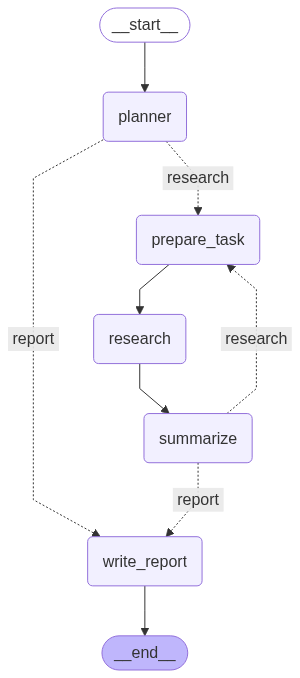


✅ Workflow visualization generated successfully


In [ ]:
from IPython.display import Image, display

try:
    # Generate the workflow visualization with higher retry settings
    graph_image = app.get_graph().draw_mermaid_png(
        draw_method="pyppeteer",  # Use local rendering
        output_file_path="workflow_graph.png"
    )
    display(Image(graph_image))
    print("\n✅ Workflow visualization generated successfully")
except Exception as e:
    # If pyppeteer not installed, try with API with more retries
    try:
        graph_image = app.get_graph().draw_mermaid_png(
            max_retries=5,
            retry_delay=2.0
        )
        display(Image(graph_image))
        print("\n✅ Workflow visualization generated successfully")
    except:
        print(f"📊 Visualization requires additional dependencies")
        # Keep the ASCII art as fallback

# Research Execution

## Launching the Multi-Agent Swarm
Observe as the team of specialized agents collaborates to research and analyze complex topics.  
The system delivers real-time updates as each agent completes their tasks, ensuring full transparency throughout the research process.


In [ ]:
import time
from typing import Any

def execute_research(topic: str) -> Dict[str, Any]:
    """
    Orchestrates the complete research workflow for a given topic.
    Provides detailed progress updates throughout the process.
    """

    print(f"\n{'='*60}")
    print(f"🚀 INITIATING MULTI-AGENT RESEARCH SWARM")
    print(f"{'='*60}")
    print(f"\n📋 Research Topic: {topic}")
    print(f"{'='*60}\n")

    # Initialize the research state
    initial_state = {
        "original_topic": topic,
        "plan": [],
        "research_data": {},
        "summaries": {},
        "final_report": "",
        "_current_task": None
    }

    # Track execution progress
    step_count = 0

    # Stream the workflow execution
    for event in app.stream(initial_state):
        step_count += 1

        for node_name, node_output in event.items():
            print(f"\n{'─'*50}")
            print(f"Step {step_count}: {node_name.upper()} AGENT")
            print(f"{'─'*50}")

            if node_name == "planner":
                plan = node_output.get('plan', [])
                print(f"✅ Research plan created with {len(plan)} tasks:")
                for i, task in enumerate(plan, 1):
                    print(f"   {i}. {task[:80]}...")

            elif node_name == "prepare_task":
                current = node_output.get('_current_task', '')
                remaining = len(node_output.get('plan', []))
                print(f"📌 Current Focus: {current[:100]}...")
                print(f"📊 Remaining Tasks: {remaining}")

            elif node_name == "research":
                current = node_output.get('_current_task', '')
                data_count = len(node_output.get('research_data', {}).get(current, []))
                print(f"🔍 Research completed for current task")
                print(f"📚 Sources gathered: {data_count}")

            elif node_name == "summarize":
                current = node_output.get('_current_task', '')
                summary = node_output.get('summaries', {}).get(current, '')
                print(f"📝 Summary generated")
                print(f"📏 Length: {len(summary)} characters")

            elif node_name == "write_report":
                report_length = len(node_output.get('final_report', ''))
                print(f"📄 Final report generated")
                print(f"📏 Length: {report_length} characters")

            time.sleep(0.5)  # Brief pause for readability

    print(f"\n{'='*60}")
    print(f"✅ RESEARCH COMPLETE")
    print(f"{'='*60}\n")

    # Get the complete final state instead of just last node output
    complete_state = app.invoke(initial_state)
    return complete_state


# Execute research on a cutting-edge topic
research_topic = "The Impact of Quantum Computing on Modern Cryptography and Cybersecurity"
final_state = execute_research(research_topic)


🚀 INITIATING MULTI-AGENT RESEARCH SWARM

📋 Research Topic: The Impact of Quantum Computing on Modern Cryptography and Cybersecurity


──────────────────────────────────────────────────
Step 1: PLANNER AGENT
──────────────────────────────────────────────────
✅ Research plan created with 7 tasks:
   1. 1. **What are the fundamental principles of quantum computing, and how do they d...
   2. - This question seeks to establish a foundational understanding of quantum compu...
   3. 2. **What are the current cryptographic algorithms that are widely used in cyber...
   4. - This question aims to identify and analyze existing cryptographic protocols, s...
   5. 3. **What potential quantum algorithms pose the greatest threat to current crypt...
   6. - This question will delve into specific quantum algorithms, particularly Shor's...
   7. 4. **What are the proposed quantum-resistant cryptographic solutions, and how do...

──────────────────────────────────────────────────
Step 2: PREPARE_TASK 

# Research Report Output

## Final Deliverable
The culmination of multi-agent collaboration—a comprehensive, professionally formatted research report demonstrating the power of orchestrated AI intelligence.


In [ ]:
from IPython.display import Markdown, display

print("="*60)
print("📖 FINAL RESEARCH REPORT")
print("="*60)
print()

# Display the formatted report
display(Markdown(final_state.get('final_report', 'Report generation in progress...')))

# Report metadata
print("\n" + "="*60)
print("📊 REPORT STATISTICS")
print("="*60)
summaries_count = len(final_state.get('summaries', {}))
total_sources = sum(len(v) for v in final_state.get('research_data', {}).values())
report_words = len(final_state.get('final_report', '').split())

print(f"✓ Research Areas Covered: {summaries_count}")
print(f"✓ Total Sources Analyzed: {total_sources}")
print(f"✓ Report Word Count: ~{report_words}")
print(f"✓ Processing Pipeline: 5 Specialized Agents")
print("="*60)

📖 FINAL RESEARCH REPORT



# The Impact of Quantum Computing on Modern Cryptography and Cybersecurity

## Executive Summary

The advent of quantum computing represents a monumental shift in the landscape of technology, particularly in the fields of cryptography and cybersecurity. Traditional cryptographic algorithms, which have securely underpinned digital communications for decades, are now facing unprecedented threats from quantum algorithms capable of breaking their foundational principles. This report delves into the fundamental principles of quantum computing, analyzes the vulnerabilities of current cryptographic systems, evaluates the potential impact of quantum algorithms, and discusses emerging post-quantum cryptographic solutions. With the clock ticking on the security of sensitive data, organizations must proactively adapt to this evolving paradigm to safeguard their digital assets against future quantum threats.

## Introduction

Quantum computing is poised to revolutionize numerous sectors by solving complex problems at speeds unattainable by classical computing. As we transition into this new era, understanding the implications of quantum technology on cryptography and cybersecurity is essential. This report is structured to provide an in-depth exploration of the principles of quantum computing, assess the vulnerabilities of existing cryptographic algorithms, evaluate the threats posed by specific quantum algorithms, and investigate the development of quantum-resistant cryptographic solutions.

## 1. Understanding Quantum Computing

### 1.1 Fundamental Principles

Quantum computing diverges from classical computing primarily through the use of **qubits** instead of bits. While classical bits can exist in a binary state of 0 or 1, qubits can represent both states simultaneously due to **superposition**. This property allows quantum computers to perform multiple calculations concurrently, vastly increasing their computational speed and efficiency—particularly for complex tasks such as cryptography.

Moreover, **entanglement**—a phenomenon where qubits become interconnected—enables quantum algorithms to process vast amounts of data more accurately than classical systems. By leveraging these principles, quantum computing has the potential to address computational challenges that are currently insurmountable for classical systems.

### 1.2 Comparison with Classical Computing

In contrast to classical computing's deterministic and linear approach, quantum computing employs probabilistic methods to explore solution spaces. Classical algorithms execute calculations in a straightforward sequence, while quantum algorithms can yield multiple potential outcomes simultaneously. This fundamental difference in operation positions quantum computing as a formidable force capable of revolutionizing industries reliant on complex problem-solving.

## 2. Current Cryptographic Algorithms and Their Vulnerabilities

### 2.1 Overview of Cryptographic Algorithms

The cryptographic landscape is dominated by several widely used algorithms, including **RSA**, **Advanced Encryption Standard (AES)**, and **Elliptic Curve Cryptography (ECC)**. These methods rely heavily on mathematical principles that are computationally intensive for classical computers, providing a strong layer of security for digital communications.

### 2.2 Vulnerabilities Exposed by Quantum Computing

Current research reveals that established asymmetric encryption methods, such as RSA and ECC, are highly susceptible to quantum threats. **Shor's algorithm**, for instance, can factor large integers efficiently, thereby compromising RSA’s security framework. Similarly, ECC, which relies on the difficulty of discrete logarithms, is also at risk. 

While symmetric encryption methods like AES are relatively more resilient, they are not entirely immune to quantum attacks. **Grover's algorithm** can effectively halve the brute-force search space, making it feasible for quantum systems to launch quicker decryption attempts. As a result, the cryptographic community is urgently exploring quantum-resistant alternatives to address these vulnerabilities.

## 3. Quantum Threats to Cryptographic Systems

### 3.1 Key Quantum Algorithms

The most notable quantum algorithms threatening existing cryptographic systems are **Shor's algorithm** and **Grover's algorithm**. Shor's algorithm poses a serious risk to public-key cryptography by efficiently solving the mathematical problems that underpin RSA and ECC. Conversely, Grover's algorithm accelerates the brute-force attack process on symmetric key systems like AES, effectively undermining their security.

### 3.2 Implications for Data Security

The implications of these quantum algorithms extend beyond computational efficiency; they necessitate a paradigm shift in how data security is approached. The concept of "store now, harvest later" highlights the strategic risk of storing encrypted data today that could be decrypted once quantum computing becomes feasible. Thus, organizations must adapt their cryptographic strategies to preemptively mitigate these risks.

## 4. Emerging Post-Quantum Cryptographic Solutions

### 4.1 Development of Quantum-Resistant Algorithms

In response to the challenges posed by quantum computing, researchers are actively developing **post-quantum cryptographic algorithms**. The National Institute of Standards and Technology (NIST) is leading the charge in standardizing these new algorithms. Among the most promising candidates are lattice-based cryptography, hash-based signatures, and quantum key distribution techniques.

### 4.2 Comparison with Traditional Methods

Post-quantum algorithms aim to maintain security against both classical and quantum threats. For instance, lattice-based cryptography is built on mathematical problems that remain difficult for quantum computers to solve. These algorithms, while potentially more complex and resource-intensive, offer a robust alternative to traditional methods that are now at risk.

## 5. Conclusion and Future Implications

In conclusion, the intersection of quantum computing and cryptography presents a significant challenge for the future of data security. As quantum technologies continue to evolve, the vulnerabilities of current cryptographic systems will become increasingly pronounced. Organizations must prioritize the transition to quantum-resistant algorithms to safeguard their data against emerging threats. The urgency of this transition cannot be overstated, as the implications of inaction could lead to catastrophic breaches of sensitive information.

### Key Takeaways
- Quantum computing fundamentally alters computational capabilities, exposing vulnerabilities in traditional cryptographic algorithms.
- Shor's and Grover's algorithms pose significant threats, necessitating a shift towards post-quantum cryptographic solutions.
- Ongoing efforts by organizations like NIST are crucial in developing and standardizing quantum-resistant algorithms.
- Proactive adaptation and crypto-agility are imperative for organizations to secure their digital infrastructures in the face of quantum advancements.

### Future Implications
As we move closer to a post-quantum world, the implementation of robust cryptographic frameworks will be essential. Organizations must remain vigilant, continuously reassessing their cybersecurity strategies to integrate emerging technologies and methodologies to ensure the integrity and confidentiality of their data in an increasingly complex technological landscape.


📊 REPORT STATISTICS
✓ Research Areas Covered: 14
✓ Total Sources Analyzed: 56
✓ Report Word Count: ~967
✓ Processing Pipeline: 5 Specialized Agents


In [ ]:
# Display sources analyzed
print("\n" + "="*60)
print("🔗 SOURCES ANALYZED")
print("="*60)
for topic, sources in final_state.get('research_data', {}).items():
    print(f"\n📌 {topic[:80]}...")
    for i, source in enumerate(sources, 1):
        # Extract URL from source if present
        if "Source:" in source:
            url = source.split("Source:")[-1].strip()
            print(f"   {i}. {url}")
print("="*60)


🔗 SOURCES ANALYZED

📌 1. **What are the fundamental principles of quantum computing, and how do they d...
   1. https://www.bluequbit.io/quantum-computing-vs-classical-computing
   2. https://www.bluequbit.io/quantum-computing-basics
   3. https://www.berkeleynucleonics.com/august-23-2024-quantum-computing-vs-classical-computing
   4. https://www.quantropi.com/quantum-versus-classical-computing-and-the-quantum-threat/

📌 - This question seeks to establish a foundational understanding of quantum compu...
   1. https://www.spinquanta.com/news-detail/quantum-computing-vs-classical-computing-full-breakdown
   2. https://vasscompany.com/en/insights/blogs-articles/quantum-computing/
   3. https://www.bluequbit.io/quantum-computing-basics
   4. https://azure.microsoft.com/en-us/resources/cloud-computing-dictionary/what-is-a-qubit

📌 2. **What are the current cryptographic algorithms that are widely used in cyber...
   1. https://vivatechnology.com/news/quantum-s-impact-on-cybersecurity
   2.